In [22]:
# Descarga de librerías

# Linux only, doesn't work on windows
# ! python -c "import ortools" 2>/dev/null  && echo "OR-Tools is already installed" || pip install ortools -q
# ! [[ ! -d eda ]]  && echo "Downloading eda repo" && curl -L  https://github.com/rilianx/eda/archive/refs/heads/main.tar.gz | tar xzvf - && mv eda-main eda
# import torch


# ! curl -LO https://github.com/rilianx/eda/archive/refs/heads/main.tar.gz
# ! 7z x main.tar.gz
# ! 7z x main.tar
# ! move eda-main eda
# ! del main.tar.gz
# ! del main.tar
# # Yo no lo descargo porque ya lo tengo
# !pip install tqdm

### state2vecSeq

In [155]:
# Generación de datos


from copy import deepcopy
import random
import math

import numpy as np
from torch.nn.functional import one_hot
from eda.TSP import TSP_Instance, TSP_Environment, TSP_State
from eda.solveTSP_v2 import solve
env = TSP_Environment

def distance(punto1, punto2):
    return math.sqrt((punto1[0] - punto2[0])**2 + (punto1[1] - punto2[1])**2)

# función para transformar un estado tsp en una secuencia de vectores
# para el modelo basado en capas de atención
def state2vecSeq(self):
    # creamos dos diccionarios para mantenre un mapeo de los
    # movimientos con los índices de la secuencia del modelo de aprendizaje

    city_locations = self.inst_info.city_locations

    idx2move = dict()
    move2idx = dict()
    origin = city_locations[self.visited[-1]]
    destination = city_locations[self.visited[0]]

    origin_dist = 0.0
    dest_dist = distance(origin, destination)

    seq = [list(origin) + [1, 0] + [origin_dist, dest_dist], # Última ciudad visitada (origen)
            list(destination) + [0, 1] + [dest_dist, 0.0]]  # Ciudad final

    idx2move[0] = None
    idx2move[1] = ("constructive", self.visited[0])
    move2idx[self.visited[0]] = 1

    idx = 2
    for i in self.not_visited:
        point = list(city_locations[i])
        origin_dist = distance( point, origin)
        dest_dist = distance( point, destination)
        city_vector = list(point) + [0, 0] + [origin_dist, dest_dist] # Otras ciudades

        seq.append(city_vector)
        idx2move[idx] = ("constructive", i)
        move2idx[i] = idx
        idx += 1

    return seq, idx2move, move2idx

In [156]:
## Todos los modelos serán entrenados con el mismo dataset
# X: [20000, 11, 6], Y: [20000, 11]
# donde X: (nb_sample, max_cities + 1, param_count), Y: (nb_sample, max_cities+1)

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split

import gc

import pandas as pd

from tqdm import tqdm
class Model:
    class CustomModel(nn.Module):
        def __init__(self, input_dim, num_heads, head_dim, dropout_rate=0.2):
            super(Model.CustomModel, self).__init__()
            self.num_heads = num_heads
            self.head_dim = head_dim,
            self.dropout_rate = dropout_rate

            self.input_projection = nn.Linear(input_dim, num_heads * head_dim)

            self.mha = nn.MultiheadAttention(embed_dim = num_heads * head_dim,
                                             num_heads = num_heads,
                                             dropout = dropout_rate)

            self.positionwise_linear = nn.Linear(num_heads * head_dim, 1)
        def forward(self, x, seq_lengths=10, return_probabilities=False):
            # x: [batch_size, seq_length, input_dim]
            x = x.float()
            
            max_len = x.shape[1]
            
            # Generar máscara de atención basada en las longitudes de las secuencias
            attn_mask = None
            
            # Aplicar proyección de entrada
            x_proj = self.input_projection(x)
            x_proj = x_proj.permute(1, 0, 2)  # Reordenar para multihead_attention: [seq_length, batch_size, num_heads*head_dim]
            
            
            # Aplicar atención multi-cabeza
            attn_output, _ = self.mha(x_proj, x_proj, x_proj, attn_mask=attn_mask)
            attn_output = attn_output.permute(1, 0, 2)  # Reordenar de vuelta: [batch_size, seq_length, num_heads*head_dim]
            
            # Aplicar la capa lineal posición por posición
            # Usamos una capa lineal que se aplica a cada vector de salida de la atención de forma independiente
            positionwise_output = self.positionwise_linear(attn_output)
            
            # Flatten
            flat_output = positionwise_output.view(positionwise_output.size(0), -1)  # [batch_size, seq_length]
            
            # Softmax
            if return_probabilities:
                output = F.softmax(flat_output, dim=-1)
                return output
            else: #return logits
                return flat_output
            
        
    # El modelo se genera en el constructor y se guarda en self.model
    def __init__(self, 
         input_dim = 6,
         num_heads = 10,
         head_dim = 128,
         city_count = 50,
                 
         batch_size = 512,
         train_split = 0.5,
         nb_samples = 20000,
         epochs = 5):

        self.city_count = city_count # Número de ciudades a evaluar
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        ## Parámetros modelo
        self.input_dim = input_dim  # Dimensión de la entrada
        self.num_heads = num_heads  # Número de cabezas en la atención multi-cabeza
        self.head_dim = head_dim  # Dimensión de cada cabeza
        ## Parámetros entrenamiento
        self.batch_size = batch_size
        self.train_split = train_split
        self.nb_samples = nb_samples
        self.epochs = epochs

        
        self.model = None
    
    
    def load_model(self):
        self.model = Model.CustomModel(input_dim=self.input_dim, num_heads=self.num_heads, head_dim=self.head_dim)
        self.model = self.model.to(self.device)

    def unload_model(self):
        del self.model
        torch.cuda.empty_cache()
        gc.collect()


    def train(self, x, y, num_iter=-1, use_progress_bar=False):
        self.load_model()
        # Asumiendo que X_padded y Y_stacked ya están definidos y son tensores de PyTorch
        dataset = TensorDataset(x, y)
    
        # Dividir el dataset en entrenamiento y prueba
        train_size = int(self.train_split * len(dataset))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
    
        # Definir el modelo, la función de pérdida y el optimizador
        loss_function = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters())
    
        # Initialize the DataFrame to store training results
        df = pd.DataFrame(columns=["Model Name", "cities", "iter", "Epoch",
                                   "Training Loss", "Training Accuracy",
                                   "Validation Loss", "Validation Accuracy"])
    
        # Initialize the progress bar for epochs if required
        epoch_range = range(self.epochs)
        if use_progress_bar:
            epoch_range = tqdm(epoch_range, desc="Training Epochs", unit="epoch", position = 0, leave = True)
        
        print("Entrenando modelo...")
        for epoch in epoch_range:
            self.model.train()
            train_loss = 0
            correct = 0
            total = 0
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()  # Limpia los gradientes
                outputs = self.model(X_batch)  # Obtenemos logits
                loss = loss_function(outputs, y_batch.argmax(dim=1))  # Calcular la pérdida
                loss.backward()  # Backward pass
                optimizer.step()  # Actualizar parámetros
                train_loss += loss.item() * X_batch.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch.argmax(dim=1)).sum().item()
    
            train_loss /= len(train_loader.dataset)
            train_accuracy = 100 * correct / total
    
            # Validación
            self.model.eval()
            validation_loss = 0
            correct = 0
            total = 0
            with torch.no_grad():
                for X_batch, y_batch in test_loader:
                    outputs = self.model(X_batch)
                    loss = loss_function(outputs, y_batch.argmax(dim=1))
                    validation_loss += loss.item() * X_batch.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    total += y_batch.size(0)
                    correct += (predicted == y_batch.argmax(dim=1)).sum().item()
    
            validation_loss /= len(test_loader.dataset)
            validation_accuracy = 100 * correct / total
    
            # Log results to DataFrame
            df = pd.concat([df, pd.DataFrame([{
                "Model Name": type(self).__name__,
                "cities": self.city_count,
                "iter": num_iter,
                "Epoch": epoch + 1,
                "Training Loss": train_loss,
                "Training Accuracy": train_accuracy,
                "Validation Loss": validation_loss,
                "Validation Accuracy": validation_accuracy
            }])], ignore_index=True)
    
            # print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
            # print(f'Epoch {epoch+1}, Val Loss: {validation_loss:.4f}, Val Accuracy: {validation_accuracy:.2f}%')
    
        # If tqdm was used, close the progress bar
        if use_progress_bar:
            epoch_range.close()

        return df;



    def generate_data(self, use_progress_bar=False):
        X = []  # Lista para almacenar las secuencias de entrada
        Y = []  # Lista para almacenar las etiquetas objetivo (las siguientes ciudades a visitar)
        seq_len = self.city_count + 1  # Longitud de la secuencia, ajustada para incluir una ciudad extra
        
        # If the flag is set, initialize the progress bar
        pbar = tqdm(total=self.nb_samples, desc="Generating data", unit="sample", position=0, leave=True) if use_progress_bar else None
        
        # Bucle para generar datos hasta alcanzar el número deseado de muestras
        while True:
            # 1. Generamos instancia aleatoria
            n_cities = self.city_count
            dim = 2  # Dimensión para las coordenadas de la ciudad (2D: x, y)
            city_points = np.random.rand(n_cities, dim)  # Generar puntos aleatorios para las ciudades
            inst_info = TSP_Instance(city_points)
    
            # 2. Resolvemos TSP usando algoritmo tradicional
            solution = solve(city_points)  # Resolver el TSP y obtener un estado final
    
            # 3. Iteramos sobre los movimientos de la solución final para generar varias muestras:
            # estado (X) -> movimiento (Y)
            current_state = TSP_State(inst_info)
            env.state_transition(current_state, ("constructive", solution.visited[0]))
            samples_per_sol = self.city_count - 1  # Número máximo de muestras por solución
            
            for move in [("constructive", city) for city in solution.visited[1:]]:
                seq, _, move2idx = state2vecSeq(current_state)  # Convertir el estado actual a secuencia vectorizada
    
                X.append(torch.tensor(seq))  # Añadir la secuencia a X
                Y.append(one_hot(torch.tensor(move2idx[move[1]]), num_classes=seq_len))
                #Y.append(to_categorical(move2idx[move[1]], num_classes=seq_len))  # Añadir el movimiento como categoría a Y
    
                env.state_transition(current_state, move)  # Hacer la transición al siguiente estado
    
                # Actualizar el progreso de la barra si se está usando
                if use_progress_bar:
                    pbar.update(1)
    
                # Condiciones de parada basadas en el número de ciudades visitadas/no visitadas o muestras generadas
                if len(current_state.visited) > samples_per_sol or len(X) >= self.nb_samples:
                    break
    
            # Romper el bucle externo si se ha alcanzado el número deseado de muestras
            if len(X) >= self.nb_samples:
                break
        
        # Close the progress bar if it was used
        if use_progress_bar:
            pbar.close()
    
        X_padded = torch.nn.utils.rnn.pad_sequence(X, batch_first=True)
        
        return X_padded, torch.stack(Y)

In [157]:
# X, Y = m.generate_data(use_progress_bar=True)


In [158]:
m = Model()

# device = m.device
# X = X.to(device)
# Y = Y.to(device)

In [159]:
import pandas as pd
df = pd.DataFrame(columns=["Model Name", "cities", "iter", "Epoch", "Training Loss", "Training Accuracy", "Validation Loss", "Validation Accuracy"])
df

dfb = pd.DataFrame(columns=["Model Name", "cities", "iter", "avg path cost"])

import gc
models = [m]
# for city_count in [10, 50, 100, 500]:
num_iters=1
# for city_count in [50]:

from eda.TSP import TSP_Instance, TSP_Environment, TSP_State, evalConstructiveActions, plot_tour
from eda.agents import SingleAgentSolver, GreedyAgent
import numpy as np

city_count = 50
k_folds = 5
eval_count = 50
class ModelEvalActions():
  def __init__(self, model):
    self.model=model

  # permite evaluar acctiones de varios estados a la vez
  # para optimizar los cáluclos del modelo
  def __call__(self, states, env):
    single_state = False
    if not isinstance(states, list):
      single_state=True
      states = [states]

    evals = [list() for _ in states]
    vecSeqs=[]; move2idx =[]

    for state in states:
      vecSeq, _, mov2idx = state2vecSeq(state)
      vecSeqs.append(vecSeq)
      move2idx.append(mov2idx)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    predictions = self.model(torch.tensor(vecSeqs).to(device), return_probabilities=True)

    for k in range(len(states)):
      state = states[k]
      for action in env.gen_actions(state, "constructive"):
          idx = move2idx[k][action[1]] #mapping from move to output index (model)
          evals[k].append((action,predictions[k][idx]))

    if single_state: return evals[0]
    else: return evals

for iter in range(num_iters):
    X = None
    Y = None
    for model in models:
        if X == None and Y == None:
            print(f"Generando datos iteración i={iter}")
            X, Y = model.generate_data(use_progress_bar=True)
            X = X.to(model.device)
            Y = Y.to(model.device)
        
        name = type(model).__name__
        print("Entrenando", name, "con n=", city_count)
        trained_model_df = model.train(X, Y, num_iter=iter, use_progress_bar=True)
        # Evaluación post entrenamiento
        print("Evaluando modelo: Generando 20 instancias")
        instances = [
            TSP_Instance(np.random.rand(model.city_count, 2)) for _ in tqdm(
                range(eval_count), desc="Instancias", unit="instance", position=0, leave=True)
        ]
        greedy = SingleAgentSolver (env,GreedyAgent(ModelEvalActions(model.model)))
        solutions = []
        for instance in tqdm(instances, desc="Solving Instances", unit="instance", position=0, leave=True):
            solution, *_ = greedy.solve(TSP_State(instance, visited=[0]))
            solutions.append(solution.cost)
            dfb = pd.concat([dfb, pd.DataFrame([{
                "Model Name": type(model).__name__,
                "iter": iter,
                "cities": model.city_count,
                "path cost": solution.cost
            }])])

        solutions_prom = sum(solutions) / len(solutions)

        
    del X
    del Y
    X = None
    Y = None


df

Generando datos iteración i=0


Generating data: 100%|█████████████████████████████████████████████████████| 20000/20000 [00:09<00:00, 2055.06sample/s]


Entrenando Model con n= 50


Training Epochs:   0%|                                                                        | 0/5 [00:00<?, ?epoch/s]

Entrenando modelo...


C:\Users\krr\AppData\Local\Temp\ipykernel_115332\530895605.py:168: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{
Training Epochs: 100%|████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.29s/epoch]


Evaluando modelo: Generando 20 instancias


Solving Instances: 100%|█████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 13.92instance/s]


,Model Name,cities,iter,Epoch,Training Loss,Training Accuracy,Validation Loss,Validation Accuracy


In [160]:
dfb

,Model Name,cities,iter,avg path cost,path cost
0,Model,50,0,NaN,6.276221
0,Model,50,0,NaN,6.807765
0,Model,50,0,NaN,6.643903
0,Model,50,0,NaN,6.641827
0,Model,50,0,NaN,7.367273
0,Model,50,0,NaN,6.922800
0,Model,50,0,NaN,7.428880
0,Model,50,0,NaN,7.016488
0,Model,50,0,NaN,7.016114
0,Model,50,0,NaN,7.086279


In [161]:
dfb.groupby(["Model Name"]).mean()

,cities,iter,avg path cost,path cost
Model Name,,,,
Model,50.0,0.0,NaN,6.856831


OR-Tools: 5.669952318696905


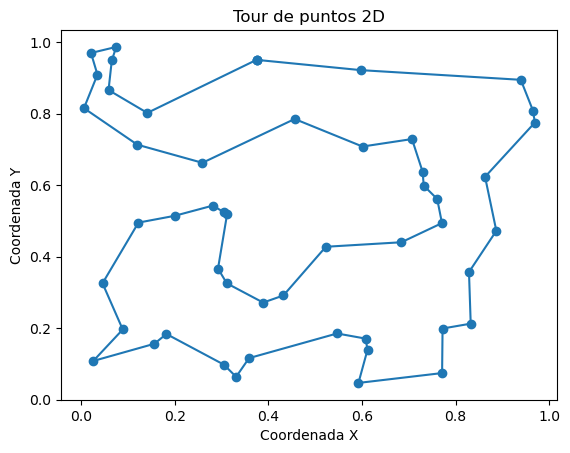

Reduced model 6.1548419782985935


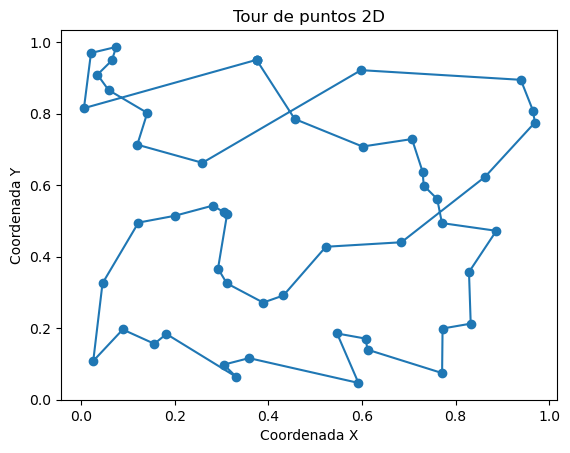

Greedy solution:
 Tour actual: [0, 12, 4, 37, 43, 1, 46, 47, 19, 48, 9, 30, 42, 11, 23, 8, 32, 13, 20, 29, 28, 2, 7, 18, 41, 39, 24, 15, 10, 14, 38, 35, 6, 31, 44, 40, 25, 17, 26, 27, 22, 45, 33, 3, 21, 16, 34, 5, 36, 49, 0], 
Coste total: 6.947554613501359


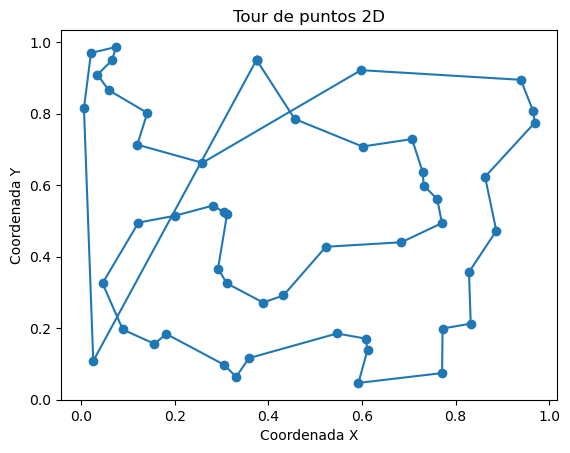

In [162]:
from eda.TSP import plot_tour, evalConstructiveActions
from eda.solveTSP_v2 import solve


np.random.seed(42)

cities = np.random.rand(m.city_count, 2)
solution = solve(cities)
print ("OR-Tools:",solution.cost)
plot_tour(cities, solution.visited)


greedy = SingleAgentSolver(env, GreedyAgent(ModelEvalActions(m.model)))
inst_info = TSP_Instance(cities)
random_instance = TSP_State(inst_info, visited=[0])
solution, *_ = greedy.solve(random_instance)
solution.cost
print("Reduced model", solution.cost)
plot_tour(cities, solution.visited)

greedy2 = SingleAgentSolver (env,GreedyAgent(evalConstructiveActions))
solution, *_ = greedy2.solve(TSP_State (inst_info, visited=[0]))
print("Greedy solution:\n", solution)
plot_tour(cities, solution.visited)
